In [22]:
# !pip install bokeh
# !pip install holoviews

In [3]:
#Data Manipulation
import pandas as pd
import datetime as dt
import numpy as np
# from rev_ai import *
# get_transcript()
#Visualization
import matplotlib.pyplot as plt
from chord import Chord

#Text manipulation
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from gensim.parsing.preprocessing import remove_stopwords
from rake_nltk import Rake
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

In [73]:
df = pd.read_csv('AssemblyTest.csv')
df = df.rename(columns = {'start':'Time', 'speaker': 'Speaker', "text": 'Text'})
# df = df.drop(columns=['Unnamed: 0'])
df.head(3)

,Time,Speaker,Text
0,0:00,F,Hi I'm Terry.
1,0:13,A,"And with me, I have a."
2,0:17,F,Two about Bornean range.


In [74]:
#Convert to datetime
df['Time'] = pd.to_datetime(df['Time'], format = '%M:%S')

In [75]:
df['time_delta'] = df['Time'].diff()
df['time_delta'] = df['Time'].shift(periods = -1)

In [76]:
# df['time_spoken'] = df['Time'].diff()
df['talk_time'] = df['time_delta'] - df['Time']
df['talk_time'] = df['talk_time'].dt.total_seconds()

In [77]:
df['text_split'] = df['Text'].str.split()

In [78]:
df['num_words_spoken'] = df['text_split'].str.len()

In [79]:
# df.groupby(['Speaker']).count()

In [80]:
df['word_per_sec'] = df['num_words_spoken']/df['talk_time']
df.head(3)

,Time,Speaker,Text,time_delta,talk_time,text_split,num_words_spoken,word_per_sec
0,1900-01-01 00:00:00,F,Hi I'm Terry.,1900-01-01 00:00:13,13.0,"[Hi, I'm, Terry.]",3,0.230769
1,1900-01-01 00:00:13,A,"And with me, I have a.",1900-01-01 00:00:17,4.0,"[And, with, me,, I, have, a.]",6,1.500000
2,1900-01-01 00:00:17,F,Two about Bornean range.,1900-01-01 00:00:22,5.0,"[Two, about, Bornean, range.]",4,0.800000


### 1. GRAPHS: Number of Words Spoken ###

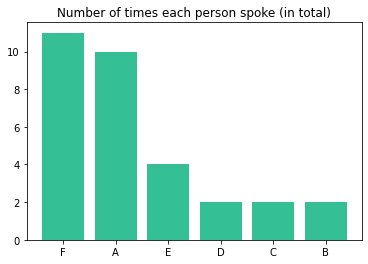

In [81]:
# How many times did each person speak?
times_each_spoke = pd.crosstab(df['Speaker'], columns = 'Speaker')
times_each_spoke = times_each_spoke['Speaker'].sort_values(ascending = False)
names = times_each_spoke.index
plt.bar(x = names, height=times_each_spoke, color = '#34bf95')
plt.title('Number of times each person spoke (in total)')
plt.show()

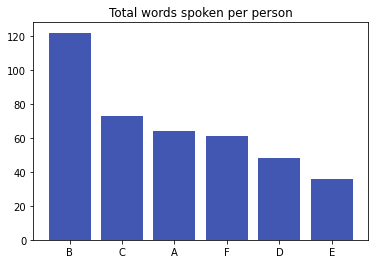

In [82]:
#How many total words did each person speak?
total_words = df.groupby('Speaker').sum()[['num_words_spoken']]
total_words = total_words.sort_values(by = 'num_words_spoken', ascending = False)
names = total_words.index
plt.bar(x = names, height=total_words['num_words_spoken'], color = '#4257b2')
plt.title('Total words spoken per person')
plt.show()

In [83]:
# plt.pie(df['Gender'])

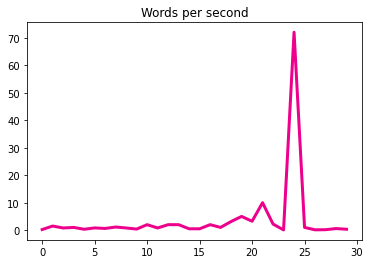

In [84]:
#Words per sec
x = df.index
y = df['word_per_sec']
colors = np.random.rand(13)
area = (30 * np.random.rand(13))**2  # 0 to 15 point radii

plt.plot(x, y, linewidth=3, color = '#ec008c')
plt.title('Words per second')
plt.show()

In [85]:
#Get chord diagram
links = df.loc[:, ('Speaker', 'num_words_spoken')]
links['Target'] = links['Speaker'].shift(periods=-1)
links['num_words_received'] = links['num_words_spoken'].shift(periods = 1)
links["Speaker"] = links["Speaker"].astype('category')
links['Speaker_cat'] = links['Speaker'].cat.codes
links["Target"] = links["Target"].astype('category')
links['Target_cat'] = links['Target'].cat.codes

crosstab = pd.crosstab(links['Speaker'], links['Target'])
names = crosstab.index.to_list()
matrix = crosstab.values.tolist()

chord = Chord(matrix, names, colors="d3.schemeSet1",opacity=0.8,
        padding=0.001,
        width=900,
        label_color="#454545",
        wrap_labels=True,
        margin=0,
        credit=True,
        font_size="20px",
        font_size_large="18px")

chord.show()

### 2. TEXTUAL ANALYSIS: Analyzing the text ###

In [86]:
import re

num_questions = df['Text'].str.contains("\?").sum()

if num_questions == 1:
    print(f'There was 1 question asked during this conversation.')
else:
    print(f'There were {num_questions} questions asked during this conversation.')

There were 0 questions asked during this conversation.


In [87]:
# (df['Text'].str.contains("\?")) &
speaker_text = df[['Speaker', 'Text']]
who_asked = speaker_text.loc[speaker_text['Text'].str.contains('\?')]
who_asked = who_asked['Speaker'].value_counts()


#Who asked the most questions?
for i, j in zip(who_asked.index, who_asked):
    if j == 1:
        print(f"{i} asked {j} question.")
    else:
        print(f"{i} asked {j} questions.")

### 3. SUMMARIZATION: The Main Point ###

In [88]:
# nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()

# Create master transcript from df['Text']
keywords = []
for i in df['Text']:
    keywords.append(i)
    
#Convert list to string
keywords = ' '.join([str(item) for item in keywords])

# Remove stopwords
no_stop = remove_stopwords(keywords)

#Create stopwords object
doc = nlp(no_stop)

#The sentence that summarizes the article;

#Today's class in a sentence or two...
summary = summarize(keywords, ratio  = .5)
summary = summary.split('.')[0]
summary = summary.split('?')[0]

In [89]:
#What's the most influential sentence in the conversation
summary

'Enrich the animals and'

### 4. RECOMMENDATION: Keywords for recommendation ###
Requirements: Needs to be string; concat list separate by spaces

In [90]:
#3 Most important words in the doc
items = [x.text for x in doc.ents]
word = Counter(items).most_common(5)

#Extracting top 5 keywords/phrases from rake
r = Rake()
r.extract_keywords_from_text(keywords)

# r.get_ranked_phrases()[0:1]
search_keywords = r.get_ranked_phrases()[0:5]

In [91]:
#Keywords for automatic web search
num_search_terms = ['1st','2nd','3rd','4th','5th','6th', '7th', '8th', '9th', '10th']

for i,j in zip(search_keywords, num_search_terms):
    print(f'The {j} search term is "{i}"')

The 1st search term is "half sister 11 year old maya"
The 2nd search term is "four year old daughter bayley"
The 3rd search term is "20 year old chesapeake"
The 4th search term is "many different research studies"
The 5th search term is "asian elephant foundation elephants"


In [92]:
#Keyword for recommender system
word[0][0]

'Terry'